<a href="https://colab.research.google.com/github/Navodini1995/datasciencecoursera/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import h5py as h5
from torch.utils import data

class MyDataset(data.Dataset):
  def __init__(self, archive, transform=None):
        self.archive = h5.File(archive, 'r')
        self.labels = self.archive['train_vessels']
        self.data = self.archive['train']
        self.transform = transform
  def __getitem__(self, index):
    datum = self.data[index]
    if self.transform is not None:
        datum = self.transform(datum)
    return datum, self.labels[index]
  def __len__(self):
    return len(self.labels)
  def close(self):
    self.archive.close()

dataset = MyDataset(data_path)

In [0]:
import h5py
import imageio
f = h5py.File(data_path)
dset = f['train']

data = np.array(dset[0,:,:])

file = '/content/gdrive/My Drive/DeepRetina/test.png' # or .jpg
imageio.imwrite(file, data)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive/My\ Drive/DeepRetina/unet_attention/*.ipynb
!cat '/content/gdrive/My Drive/DeepRetina/unet_attention/model.ipynb'
import sys
sys.path.append('gdrive/My Drive/DeepRetina/unet_attention/')
#!tar xvf "gdrive/My Drive/DeepRetina//images_train.tar.gz"

#from networks import define_G, define_D, GANLoss, print_network

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
'/content/gdrive/My Drive/DeepRetina/unet_attention/model.ipynb'
'/content/gdrive/My Drive/DeepRetina/unet_attention/train.ipynb'
{"nbformat":4,"nbformat_minor":0,"metadata":{"colab":{"name":"model.ipynb","provenance":[],"collapsed_sections":[],"authorship_tag":"ABX9TyPoIq37R4LRFYZTGeNB/fo+"},"kernelspec":{"name":"python3","display_name":"Python 3"}},"cells":[{"cell_type":"code","metadata":{"id":"HdjVV_ZMcOaB","colab_type":"code","colab":{}},"source":["# full assembly of the sub-parts to form the complete net\n","import torch\n","import torch.nn as nn\n","import torch.nn.functional as F\n","\n","class SCSEBlock(nn.Module):\n","    def __init__(self, channel, reduction=16):\n","        super().__init__()\n","        self.avg_pool = nn.AdaptiveAvgPool2d(1)\n","        self.channel_excitation = nn.Sequential(nn.Linear(channel, int(channel // reduction)),\n"," 

In [0]:
# full assembly of the sub-parts to form the complete net
import torch
import torch.nn as nn
import torch.nn.functional as F

class SCSEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.channel_excitation = nn.Sequential(nn.Linear(channel, int(channel // reduction)),
                                                nn.ReLU(inplace=True),
                                                nn.Linear(int(channel // reduction), channel))
        self.spatial_se = nn.Conv2d(channel, 1, kernel_size=1,
                                    stride=1, padding=0, bias=False)

    def forward(self, x):
        bahs, chs, _, _ = x.size()

        # Returns a new tensor with the same data as the self tensor but of a different size.
        chn_se = self.avg_pool(x).view(bahs, chs)
        chn_se = torch.sigmoid(self.channel_excitation(chn_se).view(bahs, chs, 1, 1))
        chn_se = torch.mul(x, chn_se)
        spa_se = torch.sigmoid(self.spatial_se(x))
        spa_se = torch.mul(x, spa_se)
        return torch.add(chn_se, 1, spa_se)


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)
        self.SCSE = SCSEBlock(out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x2 = F.upsample(x2, (x1.size(2), x1.size(3)), mode='bilinear')
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        x = self.SCSE(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(3, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        #print ('x_size',x.size())
        
        x1 = self.inc(x)
        #print(x1.size())
        x2 = self.down1(x1)
        #print(x2.size())
        x3 = self.down2(x2)
        #print(x3.size())
        x4 = self.down3(x3)
        #print(x4.size())
        x5 = self.down4(x4)
        #print(x5.size(), x4.size())
        #x4 = F.upsample(x4, (x5.size(2)*2, x5.size(3)*2), mode='bilinear')
        x6 = self.up1(x5, x4)
        #print(x6.size())
        x7 = self.up2(x6, x3)
        #print(x7.size())
        x8 = self.up3(x7, x2)
        #print(x8.size())
        x9 = self.up4(x8, x1)
        #print(x9.size())
        x10 = self.outc(x9)
        #print(x10.size())
        x10 = F.upsample(x10, (x.size(2), x.size(3) ), mode='bilinear')
        return F.sigmoid(x10)


In [0]:
#System
import numpy as np
import sys
import os
import random
from glob import glob
from skimage import io
from PIL import Image
import random
#Torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torch
import torchvision.transforms as standard_transforms
import h5py as h5
from torch.utils import data
import matplotlib.pyplot as plt
#from model import UNet
from torchvision.models import resnet18

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

args = {
    'num_class': 1,
    'ignore_label': 255,
    'num_gpus': 2,
    'start_epoch': 1,
    'num_epoch': 125,
    'batch_size': 1,
    'lr': 0.0001,
    'lr_decay': 0.9,
    'dice': 0,
    'weight_decay': 1e-4,
    'momentum': 0.9,
    'snapshot': '',
    'opt': 'adam',
    'pred_dir':'/content/gdrive/My Drive/DeepRetina/unet_attention/predicted/',
    'ckpt_dir': '/content/gdrive/My Drive/DeepRetina/unet_attention/ckpt/unet_scSE/',
}

class MyDataset(data.Dataset):

  def __init__(self, archive, transform=None):
        self.archive = h5.File(archive, 'r')
        self.labels = self.archive['train_vessels']
        self.data = self.archive['train']
        self.transform = transform
  
  def __getitem__(self, index):
    datum = self.data[index]
    labels_ = self.labels[index]
    if self.transform is not None:
        datum = self.transform(datum)
    labels_y = preprocess_y(labels_)
    labels__ = labels_y[None,:,:]
    datum_x = preprocess_x(datum).transpose(2,0,1)
    return datum_x, labels__
  def __len__(self):
    return len(self.labels)
  def close(self):
    self.archive.close()

def preprocess_y(inputs_):
    inputs_ /= 255.
    inputs_[inputs_ >= 0.5] = 1
    inputs_[inputs_ < 0.5] = 0
    return inputs_

def preprocess_x(inputs_):
    inputs_ /= 255.
    return inputs_


data_path = '/content/gdrive/My Drive/DeepRetina/Retinal_Work/DeepRetina/datasets/scleral_data/scleral_bbox_vessels_data512.hdf5'

dataset = MyDataset(data_path)
lengths = [ int(len(dataset)*0.8),int(len(dataset)*0.2)+1]
train_dataset, valid_dataset = torch.utils.data.random_split(dataset,lengths)
train_loader = DataLoader(dataset=train_dataset, batch_size=args['batch_size'], shuffle=True, num_workers=12, drop_last=True)

model = UNet(n_classes=1)
gpu_ids = range(args['num_gpus'])
#model = torch.nn.parallel.DataParallel(model, device_ids=gpu_ids)
model = model.cuda()
criterion = nn.BCELoss()
if args['opt'] == 'sgd':
    optimizer = optim.SGD(model.parameters(),
                          lr=0.0002,
                          momentum=0.99, weight_decay=0.0001)
elif args['opt'] == 'adam':
    optimizer = optim.Adam(model.parameters(),
                            lr=args['lr'], weight_decay=0.0001)


In [0]:

if not os.path.exists(args['ckpt_dir']):
    os.makedirs(args['ckpt_dir'])

class CrossEntropyLoss2d(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(CrossEntropyLoss2d, self).__init__()
        self.nll_loss = torch.nn.NLLLoss(weight, size_average)

    def forward(self, inputs, targets):
        return self.nll_loss(F.log_softmax(inputs), targets)



if __name__ == '__main__':
    #img_dir = '../train_train.txt'

    #print(dataset.__len__())


    #criterion = CrossEntropyLoss2d(size_average=True).cuda()

    model.train()
    epoch_iters = dataset.__len__() / args['batch_size']
    max_epoch = args['num_epoch']
    for epoch in range(max_epoch):
        for batch_idx, data in enumerate(train_loader):
            inputs, labels = data
            inputs = Variable(inputs).cuda().float()
            labels = Variable(labels).cuda().float()
            
            #print(np.unique(inputs.cpu()))
            #print(np.shape(labels.cpu()))
            optimizer.zero_grad()
            outputs = model(inputs)
            #print(np.shape(outputs.cpu()))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if (batch_idx + 1) % 20 == 0:
                print('[epoch %d], [iter %d / %d], [train main loss %.5f], [lr %.10f]' % (
                    epoch, batch_idx + 1, epoch_iters, loss.item(),
                    optimizer.param_groups[0]['lr']))

        snapshot_name = 'epoch_' + str(epoch)
        torch.save(model.state_dict(), os.path.join(args['ckpt_dir'], snapshot_name + '.pth.tar'))



In [8]:

if __name__ == '__main__':
  net =  UNet(n_classes=1).cuda()
  valid_loader = DataLoader(dataset=valid_dataset, batch_size=args['batch_size'], shuffle=True, num_workers=12, drop_last=True)
  #net = torch.nn.parallel.DataParallel(net, device_ids=[0, 1])
  #dir = '/media/mmlab/data/Datasets/BraTS/BraTS17/Brats17_valid/BraTS17_valid_mri/**'
  #patients = sorted(glob(dir), key=os.path.getmtime)
  #IMG_MEAN = np.array((23.661847049902107,23.13533027273353,26.694140535191476),dtype=np.float32)
  Best_Dice = 0
  Best_epoch=0
  
  for epochs in range(1,125):

    args['snapshot'] = 'epoch_'+ str(epochs) + '.pth.tar'
    net.load_state_dict(torch.load(os.path.join(args['ckpt_dir'], args['snapshot'])))
    net.eval()
    mdice = [];
    #scans = list((4,1))
    LOSS = 0.0
    for batch_idx, data in enumerate(valid_loader):
      inputs_val, labels_val = data
      inputs_val = Variable(inputs_val).cuda().float()
      labels_val = Variable(labels_val).cuda().float()
      #print(inputs_val.shape)
      outputs_val = net(inputs_val)
      #print(np.shape(outputs.cpu()))
      loss = criterion(outputs_val, labels_val)
      LOSS = LOSS + loss.item()
      optimizer.step()
    print('epoch',epochs,'Valid_loss',LOSS/(int(len(dataset)*0.2)+1))


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 1 Valid_loss 0.22447436761397582
epoch 2 Valid_loss 0.1990153445647313
epoch 3 Valid_loss 0.17410715554769224
epoch 4 Valid_loss 0.14118102221534803
epoch 5 Valid_loss 0.15129176383981338
epoch 6 Valid_loss 0.11703395700225463
epoch 7 Valid_loss 0.13700002976335013
epoch 8 Valid_loss 0.11129966707756886
epoch 9 Valid_loss 0.28861361226210225
epoch 10 Valid_loss 0.1415068511492931
epoch 11 Valid_loss 0.12719159988829723
epoch 12 Valid_loss 0.1229397630175719
epoch 13 Valid_loss 0.18337813549889967
epoch 14 Valid_loss 0.10687271964091521
epoch 15 Valid_loss 0.15129604677741343
epoch 16 Valid_loss 0.14774045806664687
epoch 17 Valid_loss 0.15050934971525118
epoch 18 Valid_loss 0.19035358669666144
epoch 19 Valid_loss 0.19745644547331792
epoch 20 Valid_loss 0.13203105086890551
epoch 21 Valid_loss 0.1697125886208736
epoch 22 Valid_loss 0.1273140087723732
epoch 23 Valid_loss 0.15998938135229623
epoch 24 Valid_loss 0.13806088927846688
epoch 25 Valid_loss 0.16905801069851106
epoch 26 Valid

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


TypeError: ignored

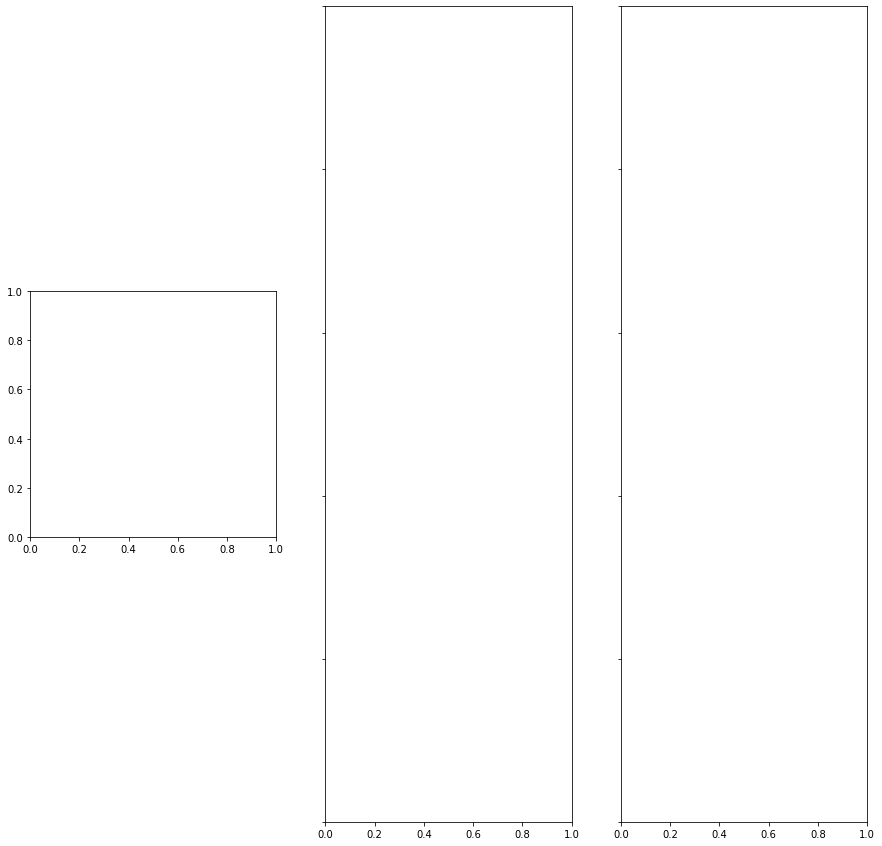

In [13]:
if __name__ == '__main__':
    net =  UNet(n_classes=1).cuda()
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=args['batch_size'], shuffle=True, num_workers=12, drop_last=True)
    Best_Dice = 0
    Best_epoch=0
    for epochs in range(84,85):

        args['snapshot'] = 'epoch_'+ str(epochs) + '.pth.tar'
        net.load_state_dict(torch.load(os.path.join(args['ckpt_dir'], args['snapshot'])))
        net.eval()
        mdice = [];
        #scans = list((4,1))
        #LOSS = 0
        for batch_idx, data in enumerate(valid_loader):
            inputs_test, labels_test = data
            inputs_test = Variable(inputs_test).cuda().float()
            labels_test = Variable(labels_test).cuda().float()
            outputs_test = net(inputs_test)
            #print(np.shape(outputs.cpu()))
            #loss = criterion(outputs, labels)
            #LOSS = LOSS + loss

            fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 15))
            ax1, ax2, ax3 = ax.ravel()
            ax1.imshow(np.squeeze(inputs_test.cpu().detach().numpy()), cmap='jet')
            ax1.set_title('Retinal Image')
            ax2.imshow(np.squeeze(labels_test.cpu().detach().numpy()))
            ax2.set_title('Annontated Vessels')
            ax3.imshow(np.squeeze(outputs_test.cpu().detach().numpy()))
            ax3.set_title('Reconstructed Vessels')
            plt.show()
            #print('epoch',epochs,'Valid_loss',LOSS/(int(len(dataset)*0.2)+1))
